In [13]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data_dir = '/content/drive/MyDrive/Colab_Notebooks/computer_vision/Smart-Attendance-AI/dataset'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
data_dir = pd.concat([Fseries, Lseries], axis= 1)
data_dir

,filepaths,labels
0,/content/drive/MyDrive/Colab_Notebooks/compute...,21115461_TuanAnhTran
1,/content/drive/MyDrive/Colab_Notebooks/compute...,21115461_TuanAnhTran
2,/content/drive/MyDrive/Colab_Notebooks/compute...,21115461_TuanAnhTran
3,/content/drive/MyDrive/Colab_Notebooks/compute...,21115461_TuanAnhTran
4,/content/drive/MyDrive/Colab_Notebooks/compute...,21115461_TuanAnhTran
...,...,...
4357,/content/drive/MyDrive/Colab_Notebooks/compute...,21105351_TongThanhLoc
4358,/content/drive/MyDrive/Colab_Notebooks/compute...,21105351_TongThanhLoc
4359,/content/drive/MyDrive/Colab_Notebooks/compute...,21105351_TongThanhLoc
4360,/content/drive/MyDrive/Colab_Notebooks/compute...,21105351_TongThanhLoc


In [5]:
# train dataframe
train_df, dummy_df = train_test_split(data_dir,  train_size= 0.8, shuffle= True, random_state= 123)

# valid and test dataframe
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.6, shuffle= True, random_state= 123)

In [6]:
# crobed image size
batch_size = 20
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=10,        # Randomly rotate images within the range [-30, 30] degrees
    width_shift_range=0.1,    # Shift images horizontally within [-20%, 20%]
    height_shift_range=0.1,   # Shift images vertically within [-20%, 20%]
    zoom_range=0.2,           # Randomly zoom in or out
    fill_mode="nearest",       # Fill in missing pixels using the nearest method
    brightness_range=(0.8, 1.2)
)

ts_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
)  # No augmentation for the test set

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 3489 validated image filenames belonging to 9 classes.
Found 523 validated image filenames belonging to 9 classes.
Found 350 validated image filenames belonging to 9 classes.


In [7]:
test_gen.class_indices

{'21060451_NguyenHungAnh': 0,
 '21073141_LePhuHao': 1,
 '21075071_NguyenHanhBaoAn': 2,
 '21090261_DuongNgocAnh': 3,
 '21094341_ChauTieuLong': 4,
 '21096911_NguyenNhatTung': 5,
 '21105351_TongThanhLoc': 6,
 '21115461_TuanAnhTran': 7,
 '21119631_NguyenMinhLong': 8}

In [9]:
# Cấu hình đầu vào
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

# Tải mô hình ResNet50 pretrained, bỏ lớp đầu ra
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=img_shape)
base_model.trainable = False  # Đóng băng các tầng pretrained

# Xây dựng mô hình
model = Sequential([
        base_model,
        Dropout(0.25),
        BatchNormalization(),
        GlobalAveragePooling2D(),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(len(test_gen.class_indices),activation='softmax')
      ])

model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 7, 7, 2048)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 7, 7, 2048)          │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         131,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │             585 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,727,881 (90.51 MB)

 Trainable params: 135,945 (531.04 KB)

 Non-trainable params: 23,591,936 (90.00 MB)

In [10]:
os.makedirs('/content/drive/MyDrive/Colab_Notebooks/computer_vision/Smart-Attendance-AI/models', exist_ok=True)
cnn_path='/content/drive/MyDrive/Colab_Notebooks/computer_vision/Smart-Attendance-AI/models'
name = 'resnet_model_9label.keras'
chk_path = os.path.join(cnn_path, name)
chk_path

'/content/drive/MyDrive/Colab_Notebooks/computer_vision/Smart-Attendance-AI/models/resnet_model_9label.keras'

In [14]:
# Callback to save the model checkpoint
checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss')
# Callback for early stopping
earlystop = EarlyStopping(monitor='accuracy',
                          min_delta=0,
                          patience=5,
                          verbose=1,
                          restore_best_weights=True)

callbacks = [checkpoint, earlystop]

In [15]:
epochs =  20  # number of all epochs in training

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_gen,
    epochs=20,
    validation_data=valid_gen,
    callbacks=callbacks)


Epoch 1/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6973 - loss: 1.0199
Epoch 1: val_loss improved from inf to 0.07654, saving model to /content/drive/MyDrive/Colab_Notebooks/computer_vision/Smart-Attendance-AI/models/resnet_model_9label.keras
175/175 ━━━━━━━━━━━━━━━━━━━━ 1285s 7s/step - accuracy: 0.6983 - loss: 1.0168 - val_accuracy: 0.9943 - val_loss: 0.0765
Epoch 2/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.9780 - loss: 0.1066
Epoch 2: val_loss improved from 0.07654 to 0.01996, saving model to /content/drive/MyDrive/Colab_Notebooks/computer_vision/Smart-Attendance-AI/models/resnet_model_9label.keras
175/175 ━━━━━━━━━━━━━━━━━━━━ 72s 413ms/step - accuracy: 0.9781 - loss: 0.1065 - val_accuracy: 0.9943 - val_loss: 0.0200
Epoch 3/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.9853 - loss: 0.0699
Epoch 3: val_loss improved from 0.01996 to 0.01409, saving model to /content/drive/MyDrive/Colab_Notebooks/computer_vision/Smart-Attendance-AI/models/re

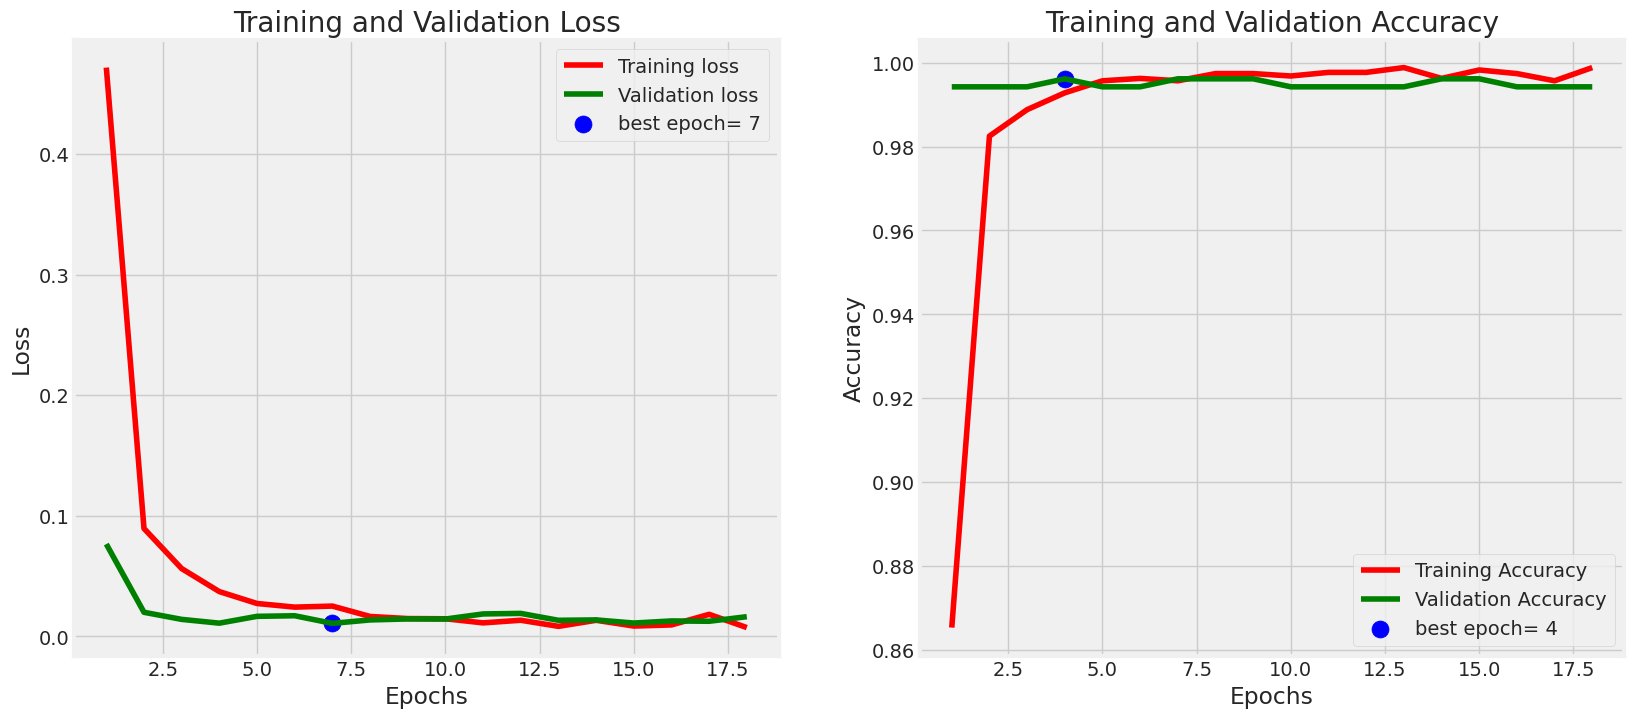

In [16]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'
# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')
plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout
plt.show()

In [17]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 360ms/step - accuracy: 1.0000 - loss: 3.3014e-04
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 5.3257e-05
5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 5s/step - accuracy: 1.0000 - loss: 1.7392e-04
Train Loss:  0.0008650154341012239
Train Accuracy:  1.0
--------------------
Validation Loss:  5.466900620376691e-05
Validation Accuracy:  1.0
--------------------
Test Loss:  0.00020193756790831685
Test Accuracy:  1.0


In [ ]:
#Save the model
model.save('../model/resnet50.keras')

In [ ]:
loaded_model = tf.keras.models.load_model('../model/resnet50.keras', compile=False)

18/18 ━━━━━━━━━━━━━━━━━━━━ 85s 5s/step


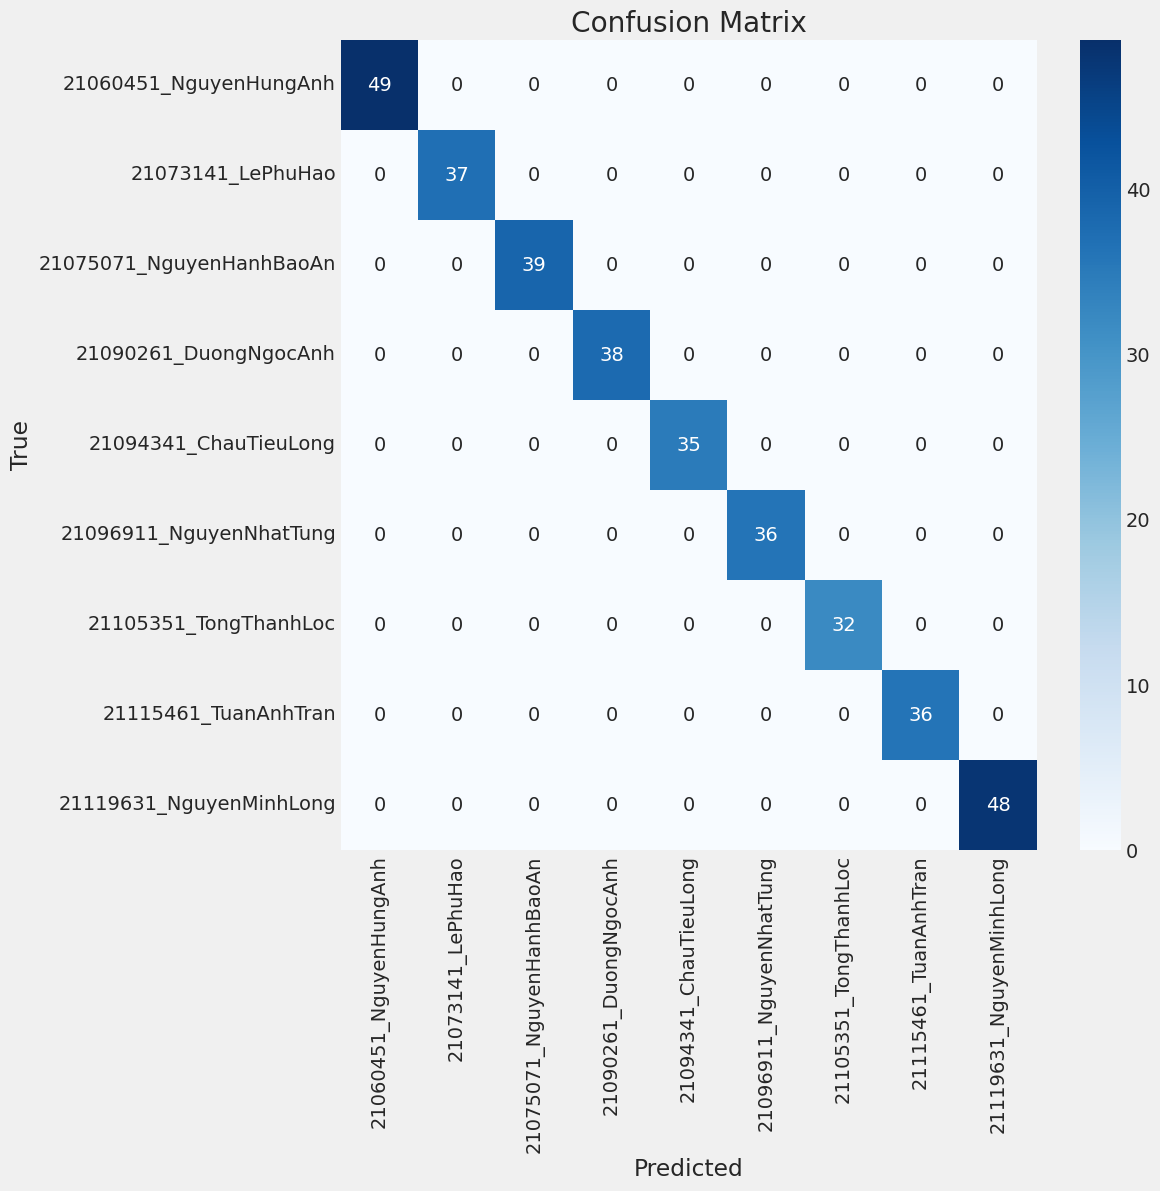

In [19]:
import seaborn as sns
# Generate predictions for the test set
predictions = model.predict(test_gen)

# Get the predicted class indices
predicted_classes = np.argmax(predictions, axis=1)

# Get the true class indices
true_classes = test_gen.classes

# Ensure that the number of true classes and predicted classes are the same
assert len(true_classes) == len(predicted_classes), "Mismatch in the number of samples between true and predicted classes"

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting with seaborn
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_gen.class_indices.keys(), yticklabels=test_gen.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [26]:
class_labels = list(test_gen.class_indices.keys())

# Generate and print the classification report
report = classification_report(true_classes,
                               predicted_classes,
                               target_names=class_labels,
                               zero_division=0)
print("Classification Report:\n", report)

Classification Report:
                           precision    recall  f1-score   support

  21060451_NguyenHungAnh       1.00      1.00      1.00        49
       21073141_LePhuHao       1.00      1.00      1.00        37
21075071_NguyenHanhBaoAn       1.00      1.00      1.00        39
   21090261_DuongNgocAnh       1.00      1.00      1.00        38
   21094341_ChauTieuLong       1.00      1.00      1.00        35
 21096911_NguyenNhatTung       1.00      1.00      1.00        36
   21105351_TongThanhLoc       1.00      1.00      1.00        32
    21115461_TuanAnhTran       1.00      1.00      1.00        36
 21119631_NguyenMinhLong       1.00      1.00      1.00        48

                accuracy                           1.00       350
               macro avg       1.00      1.00      1.00       350
            weighted avg       1.00      1.00      1.00       350



1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
Predicted class: 21094341_ChauTieuLong with confidence score: 100.00%


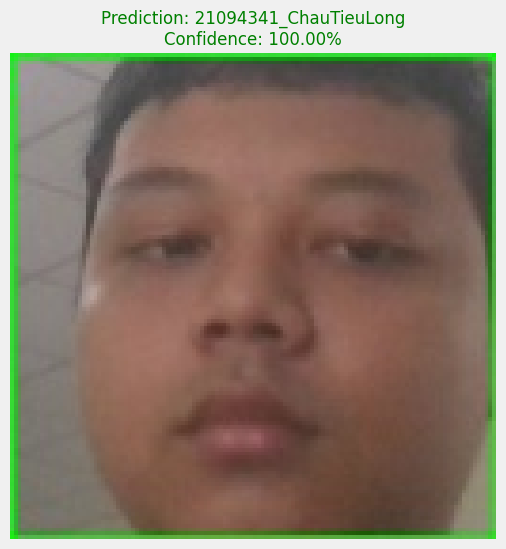

In [20]:
# Lấy tên các lớp (class labels) từ ImageDataGenerator test_gen
class_labels = list(test_gen.class_indices.keys())

# Hàm tiền xử lý ảnh
def preprocess_image(image_path, target_size):
    """
    Mở ảnh, resize, chuyển sang mảng numpy, thêm batch dimension,
    và chuẩn hóa bằng preprocess_input của ResNet50V2.
    """
    img = Image.open(image_path).convert('RGB')
    img = img.resize(target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # [1, 224, 224, 3]
    img_array = preprocess_input(img_array)
    return img_array

# Chọn một ảnh từ lớp 'ChauTieuLong' để kiểm tra
image_path = test_df[test_df["labels"] == "21094341_ChauTieuLong"].iloc[0]["filepaths"]

# Tiền xử lý ảnh đầu vào
input_shape = (224, 224)
preprocessed_image = preprocess_image(image_path, target_size=input_shape)

# Load mô hình đã huấn luyện
# model = load_model('../model/resnet50.keras')

# Dự đoán nhãn ảnh
predictions = model.predict(preprocessed_image)

# Xác định nhãn được dự đoán và độ tin cậy
predicted_class = class_labels[np.argmax(predictions)]
confidence_score = np.max(predictions)

# In kết quả dự đoán
print(f"Predicted class: {predicted_class} with confidence score: {confidence_score * 100:.2f}%")

# Hiển thị ảnh kèm nhãn dự đoán
plt.figure(figsize=(6, 6))
image = Image.open(image_path)
plt.imshow(image)
plt.axis("off")
plt.title(f"Prediction: {predicted_class}\nConfidence: {confidence_score * 100:.2f}%", fontsize=12, color='green')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


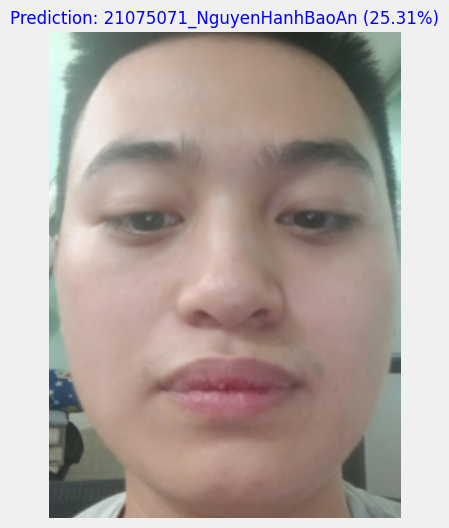

In [25]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Đường dẫn đến ảnh
image_path = '/content/drive/MyDrive/Screenshot 2025-05-04 141300.png'
image = Image.open(image_path).convert('RGB')  # <- thêm .convert('RGB')

# Tiền xử lý ảnh
input_shape = (224, 224)
preprocessed_image = preprocess_image(image_path, target_size=input_shape)

# Dự đoán

# Load mô hình đã huấn luyện
# model = load_model('../model/resnet50.keras')

# Dự đoán nhãn ảnh
predictions = model.predict(preprocessed_image)
score = tf.nn.softmax(predictions[0])

# Lấy nhãn dự đoán
g_dict = test_gen.class_indices
classes = list(g_dict.keys())
predicted_label = classes[np.argmax(score)]
confidence = 100 * np.max(score)

# Hiển thị hình ảnh và nhãn dự đoán
plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.axis("off")
plt.title(f"Prediction: {predicted_label} ({confidence:.2f}%)", fontsize=12, color='blue')
plt.show()


In [23]:
score

<tf.Tensor: shape=(9,), dtype=float32, numpy=
array([0.09336819, 0.09336227, 0.25311592, 0.09333463, 0.09333364,
       0.09337272, 0.09333535, 0.09344397, 0.09333333], dtype=float32)>

In [ ]:
import cv2
import tensorflow as tf
import numpy as np

# Load mô hình đã huấn luyện
loaded_model = tf.keras.models.load_model('../model/restnet50.keras', compile=False)
loaded_model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

# Lấy danh sách nhãn
student_ids = {
    '21060451_NguyenHungAnh': 0,
    '21090261_DuongNgocAnh': 1,
    '21094341_ChauTieuLong': 2,
    '21096911_NguyenNhatTung': 3,
    '21105351_TongThanhLoc': 4,
    '21119631_NguyenMinhLong': 5
}

g_dict = student_ids
classes = list(g_dict.keys())

# Load bộ phát hiện khuôn mặt Haarcascade
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Mở webcam
cap = cv2.VideoCapture(0)  # 0 là webcam mặc định

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Chuyển ảnh sang grayscale để tăng hiệu suất phát hiện khuôn mặt
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Phát hiện khuôn mặt
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(50, 50))

    for (x, y, w, h) in faces:
        # Cắt vùng khuôn mặt
        face = frame[y:y+h, x:x+w]

        # Tiền xử lý ảnh khuôn mặt
        face_resized = cv2.resize(face, (224, 224))  # Resize về 224x224
        img_array = tf.keras.preprocessing.image.img_to_array(face_resized)
        img_array = tf.expand_dims(img_array, axis=0)  # Thêm batch dimension

        # Dự đoán
        predictions = loaded_model.predict(img_array)
        score = tf.nn.softmax(predictions[0])

        # Lấy nhãn dự đoán
        predicted_label = classes[np.argmax(score)]
        confidence = 100 * np.max(score)

        # Vẽ hình chữ nhật xung quanh khuôn mặt
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)

        # Hiển thị nhãn dự đoán
        text = f"{predicted_label} ({confidence:.2f}%)"
        cv2.putText(frame, text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

    # Hiển thị khung hình
    cv2.imshow("Face Recognition", frame)

    # Thoát khi nhấn 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━